In [5]:
# Anil Kumar Ravuru

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv('Final.csv')
print(df['name'].count())
df.head()

69517


,name,description,message,fb_like,fb_angry,fb_thankful,fb_haha,fb_sad,fb_wow,fb_love,top_reaction_count,top_reaction,token_words,custom_token_words
0,This Korean Ad Hilariously Addresses The Power...,But how is this about the burger?,A proof that makeup and sorcery go hand in han...,1878,1,0,391,0,3,22,391,fb_haha,korean ad hilari address power makeup gag.tv,korean ad hilari address power makeup gag.tv
1,People Are Losing It For The Hiddle-Swift Split,Click to see the pic and write a comment...,My imaginary relationship with Tom Hiddleston ...,7606,5,0,1629,8,13,269,1629,fb_haha,peopl lose hiddl swift split,peopl lose hiddl swift split
2,"Sia Drops ""The Greatest"" Video Featuring 49 Da...",49 young dancers representing the 49 people lo...,Another amazing and breathtaking video from Si...,25304,6,0,95,44,367,2065,2065,fb_love,sia drop greatest video featur dancer pay trib...,sia drop greatest video featur dancer pay trib...
3,15 Tweets That Remind You Why You Need A Condo...,Click to see the pic and write a comment...,They also remind you how great your parents ar...,3452,2,0,607,0,1,62,607,fb_haha,tweet remind need condom readi,tweet remind need condom readi
4,Russian Topless Women Help Stop Speeding Drive...,Is it the breast idea ever?,"Not sure of if it will help, or cause more acc...",6454,12,0,1245,8,93,162,1245,fb_haha,russian topless woman help stop speed driver c...,russian topless woman help stop speed driver c...


In [6]:
reaction_order = ['fb_love', 'fb_haha', 'fb_wow', 'fb_sad', 'fb_angry']
df['top_reaction'] = df['top_reaction'].apply(lambda x: reaction_order.index(x))

In [15]:
# Limit the total vocab to 20000 words.
# Max token length in a row is 90
import numpy as np
vocab_size = 10000
post_length = 90
embed_dim = 100
total_rows = df['name'].count()
word_index = set()
ma = 0
for row in df['custom_token_words'].values:
    ma = max(ma, len(row))
    for word in row:
        word_index.add(row)
print('Unique Tokens: ', len(word_index))
print('Max tokens in a post: ', ma)

Unique Tokens:  63962
Max tokens in a post:  89


In [70]:
# X = [['' for _ in range(post_length)] for i in range(total_rows)]
# rows = df['custom_token_words'].values
# tokens = [row.split() for row in rows]

# for row_i in range(len(tokens)):
#     for i in range(len(tokens[row_i])):
#         X[row_i][i] = tokens[row_i][i]
# X = np.array(X)
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['custom_token_words'].values)
word_index = tokenizer.word_index
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['custom_token_words'].values)
X = pad_sequences(X, maxlen=90)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (69517, 90)


In [71]:
Y = pd.get_dummies(df['top_reaction']).values
Y.shape

(69517, 5)

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(55613, 90) (55613, 5)
(13904, 90) (13904, 5)


In [73]:
X[0][0]

0

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 50051 samples, validate on 5562 samples
Epoch 1/3
50051/50051 [==============================] - 451s 9ms/step - loss: 1.2456 - accuracy: 0.4929 - val_loss: 1.0974 - val_accuracy: 0.5658
Epoch 2/3
50051/50051 [==============================] - 433s 9ms/step - loss: 0.9785 - accuracy: 0.6251 - val_loss: 1.0930 - val_accuracy: 0.5748
Epoch 3/3
50051/50051 [==============================] - 445s 9ms/step - loss: 0.8615 - accuracy: 0.6751 - val_loss: 1.1190 - val_accuracy: 0.5735


In [76]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

13904/13904 [==============================] - 43s 3ms/step
Test set
  Loss: 1.125
  Accuracy: 0.571


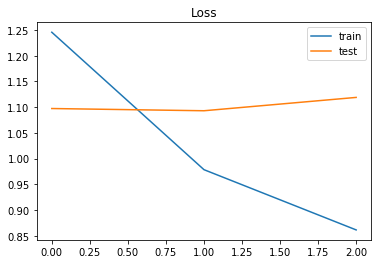

In [79]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show();

In [83]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 90, 100)           2000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 90, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 2,080,905
Trainable params: 2,080,905
Non-trainable params: 0
_________________________________________________________________


In [82]:
from keras.layers import Dense, Embedding, SpatialDropout1D, LSTM, Dropout
model2 = Sequential()
model2.add(Embedding(vocab_size, embed_dim, input_length=X.shape[1]))
model2.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dropout(0.5))
model2.add(Dense(200, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 5
batch_size = 64

history2 = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50051 samples, validate on 5562 samples
Epoch 1/5
50051/50051 [==============================] - 281s 6ms/step - loss: 1.3302 - accuracy: 0.4354 - val_loss: 1.1926 - val_accuracy: 0.5219
Epoch 2/5
50051/50051 [==============================] - 271s 5ms/step - loss: 1.0795 - accuracy: 0.5821 - val_loss: 1.1158 - val_accuracy: 0.5633
Epoch 3/5
50051/50051 [==============================] - 257s 5ms/step - loss: 0.9440 - accuracy: 0.6450 - val_loss: 1.1241 - val_accuracy: 0.5678
Epoch 4/5
50051/50051 [==============================] - 294s 6ms/step - loss: 0.8522 - accuracy: 0.6860 - val_loss: 1.1459 - val_accuracy: 0.5633
Epoch 5/5
50051/50051 [==============================] - 307s 6ms/step - loss: 0.7807 - accuracy: 0.7157 - val_loss: 1.1752 - val_accuracy: 0.5662


In [84]:
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

13904/13904 [==============================] - 22s 2ms/step
Test set
  Loss: 1.189
  Accuracy: 0.561


In [86]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 90, 100)           2000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               6600      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 2,044,229
Trainable params: 2,044,229
Non-trainable params: 0
___________________________________________

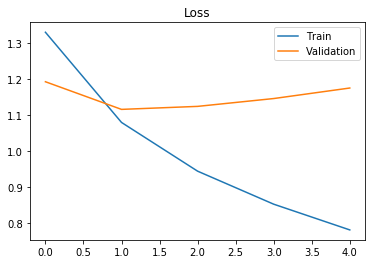

In [87]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend()
plt.show();

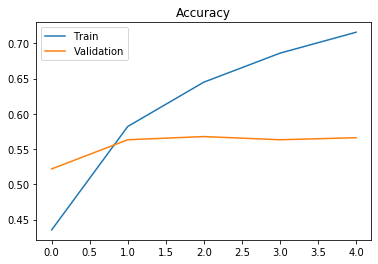

In [88]:
plt.title('Accuracy')
plt.plot(history.history2['accuracy'], label='Train')
plt.plot(history.history2['val_accuracy'], label='Validation')
plt.legend()
plt.show();

In [89]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['custom_token_words'].values)
word_index = tokenizer.word_index
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['custom_token_words'].values)
X = pad_sequences(X, maxlen=90)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (69517, 90)


In [100]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
c_model = Sequential()
c_model.add(Conv1D(filters=32, kernel_size=2, padding='Same', activation='relu', input_shape=(90,)))
c_model.add(MaxPool1D(pool_size=2))
c_model.add(Dropout(0.25))
c_model.add(Conv1D(filters=64,kernel_size=2,padding='Same',activation='relu'))
c_model.add(Conv1D(filters=64,kernel_size=2,padding='Same',activation='relu'))
c_model.add(MaxPool1D(pool_size=2,strides=2))

c_model.add(Dropout(0.25))
c_model.add(Flatten())
c_model.add(Dense(100,activation='relu'))
c_model.add(Dropout(0.5))
c_model.add(Dense(5, activation='softmax'))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
c_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 5

batch_size = 64
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)


ValueError: Input 0 is incompatible with layer conv1d_4: expected ndim=3, found ndim=2

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_rest, Y_train, Y_rest = train_test_split(X, Y, test_size = 0.4, random_state=49)
X_test, X_val, Y_test, Y_val = train_test_split(X_rest, Y_rest, test_size = 0.25, random_state=49)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(41710, 90) (41710, 5)
(6952, 90) (6952, 5)
(20855, 90) (20855, 5)


In [ ]:
final = c_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val,Y_val), callbacks=[learning_rate_reduction])